In [1]:
config_file = 'config.ini'

##### LOADING THE SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2019vxm'

# Enter the path to the directory with light curves in ATClean-readable format:
atclean_input_dir = '/Users/sofiarest/Desktop/Supernovae/data_refactor/atclean_input'

# Enter the path to the directory with cleaned and binned light curves, plots, efficiency tables, and more:
output_dir = '/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc' 

# Enter the path to a directory to optionally save any plots:
plots_dir = f'{output_dir}/{tnsname}/plots'

# Enter the filter:
filt = 'o'

# Enter the MJD bin size of the averaged light curves in days (set to None to skip loading):
mjd_bin_size = 1.00

# Optionally, enter the SN's MJD0 (if None is entered, the discovery date will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
mjd0 = 58768.040000
api_key = None
tns_id = None
bot_name = None

##### LOADING CONTROL LIGHT CURVES #####

# If True, load control light curves; else, don't
load_controls = True

# Enter the number of control light curves to load:
n_controls = 8

##### PLOTTING #####

# If True, try to calculate the best y limits automatically for each plot;
# if False, leave y limits to matplotlib 
auto_xylimits = True

In [2]:
# import dependencies
import sys, os
from download import load_config
from lightcurve import Supernova, AveragedSupernova, LightCurve, AveragedLightCurve, Cut, AandB, AnotB, AorB, not_AandB, query_tns, get_tns_mjd0_from_json
from plot import PlotLimits, Plot
from clean import hexstring_to_int, CutList
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# plot styling settings
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('legend', fontsize = 10)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5

# Load the config file

In [3]:
config = load_config(config_file)


Loading config file at config.ini...


# Load the light curves

In [4]:
print(f'SN {tnsname}, filter {filt}, {n_controls} control light curves')
if not mjd0 is None:
	print(f'SN discovery date: {mjd0}')
else:
	print(f'TNS credentials: \n\tAPI key: {api_key}\n\tTNS ID: {tns_id}\n\tBot name: {bot_name}')
print(f'Load controls: {load_controls}')
print(f'Load averaged light curves: {f"True (MJD bin size: {mjd_bin_size} days)" if not mjd_bin_size is None else "False"}')

print()
print(f'ATClean output directory (load original light curves in ATClean-readable format): \n\t{atclean_input_dir}/{tnsname}')
print(f'ATClean output directory (load cleaned light curves): \n\t{output_dir}/{tnsname}')
print(f'Plots directory (save plots): \n\t{output_dir}')

SN 2019vxm, filter o, 8 control light curves
SN discovery date: 58768.04
Load controls: True
Load averaged light curves: True (MJD bin size: 1.0 days)

ATClean output directory (load original light curves in ATClean-readable format): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/atclean_input/2019vxm
ATClean output directory (load cleaned light curves): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm
Plots directory (save plots): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc


In [5]:
if mjd0 is None:
	# get discovery date from TNS
	print(f"Querying TNS for SN {tnsname} discovery date...")
	json_data = query_tns(
		tnsname,
		api_key,
		tns_id,
		bot_name,
	)
	mjd0 = get_tns_mjd0_from_json(json_data)
	print(f"Setting MJD0 to {mjd0}")

# load cleaned light curves
sn = Supernova(tnsname=tnsname, mjd0=mjd0, filt=filt)
try:
	sn.load_all(output_dir, num_controls=n_controls, cleaned=True)
except Exception as e:
	raise RuntimeError(f"ERROR: Could not load light curves: {str(e)}")

if not mjd_bin_size is None:
	# load averaged light curves
	avg_sn = AveragedSupernova(tnsname=tnsname, mjd0=mjd0, filt=filt, mjdbinsize=mjd_bin_size)
	try:
		avg_sn.load_all(output_dir, num_controls=n_controls)
	except Exception as e:
		raise RuntimeError(f"ERROR: Could not load light curves: {str(e)}")


Loading SN light curve and 8 control light curves...
ERROR: could not read /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/controls/2019vxm_i001.o.clean.lc.txt!
Could not load control light curve 1; skipping...
Successfully loaded SN light curve and 7 control light curves

Loading averaged SN light curve and 8 averaged control light curves...
ERROR: could not read /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/controls/2019vxm_i001.o.1.00days.lc.txt!
Could not load control light curve 1; skipping...
Successfully loaded averaged SN light curve and 7 averaged control light curves


In [6]:
plot = Plot(plots_dir)

# TEMPORARY; DELETE ME
SN_FLUX_COLORS = {"o": "orange", "c": "cyan"}
SN_FLAGGED_FLUX_COLOR = "red"
CONTROL_FLUX_COLOR = "steelblue"
TEMPLATE_CHANGE_1_MJD = 58417
TEMPLATE_CHANGE_2_MJD = 58882

# Plot original SN light curve and control light curves

In [7]:
# Plot the control light curves underneath the SN light curve?
plot_controls = True

# Plot the ATLAS template changes?
plot_controls = True

# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/original.png


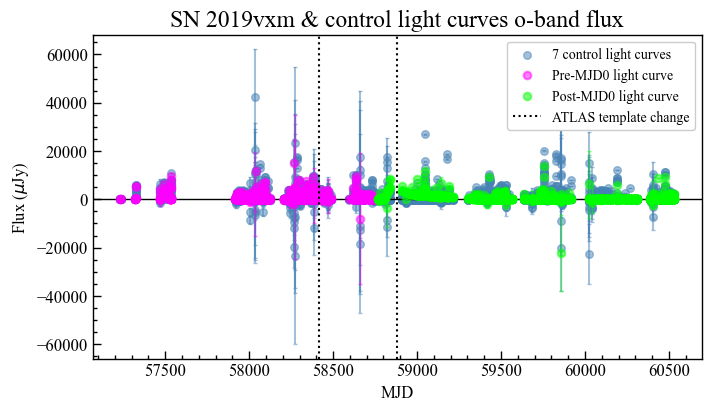

In [8]:
"""def plot_SN(
	sn: Supernova,
	lims: PlotLimits,
	plot_controls: bool = True,
	plot_template_changes: bool = True
):
	fig, ax1 = plt.subplots(1, constrained_layout=True)
	fig.set_figwidth(7)
	fig.set_figheight(4)
	
	title = f'SN {sn.tnsname}'
	if sn.num_controls > 0:
		title += f' & control light curves'
	title += f' {sn.filt}-band flux'
	ax1.set_title(title)

	ax1.minorticks_on()
	ax1.tick_params(direction='in', which='both')
	ax1.set_ylabel(r'Flux ($\mu$Jy)')
	ax1.set_xlabel('MJD')
	ax1.axhline(linewidth=1, color='k')

	if plot_controls and sn.num_controls > 0:
		# plot control light curves
		label = f'{sn.num_controls} control light curves'
		for control_index in sn.get_control_indices():
			lc = sn.lcs[control_index]

			plt.errorbar(lc.t['MJD'], lc.t['uJy'], yerr=lc.t[lc.dflux_colname], fmt='none', ecolor=CONTROL_FLUX_COLOR, elinewidth=1.5, capsize=1.2, c=CONTROL_FLUX_COLOR, alpha=0.5, zorder=0)
			plt.scatter(lc.t['MJD'], lc.t['uJy'], s=marker_size, color=CONTROL_FLUX_COLOR, marker='o', alpha=0.5, zorder=0, label=label)

			if not label is None:
				label = None

	lc = sn.lcs[0]
	preMJD0_ix = lc.get_preMJD0_indices(sn.mjd0)
	postMJD0_ix = lc.get_postMJD0_indices(sn.mjd0)

	# plot pre-MJD0 SN light curve
	plt.errorbar(lc.t.loc[preMJD0_ix,'MJD'], lc.t.loc[preMJD0_ix,'uJy'], yerr=lc.t.loc[preMJD0_ix,lc.dflux_colname], fmt='none', ecolor='magenta', elinewidth=1, capsize=1.2, c='magenta', alpha=0.5, zorder=10)
	plt.scatter(lc.t.loc[preMJD0_ix,'MJD'], lc.t.loc[preMJD0_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color='magenta', marker='o', alpha=0.5, zorder=10, label='Pre-MJD0 light curve')
	
	# plot post-MJD0 SN light curve
	plt.errorbar(lc.t.loc[postMJD0_ix,'MJD'], lc.t.loc[postMJD0_ix,'uJy'], yerr=lc.t.loc[postMJD0_ix,lc.dflux_colname], fmt='none', ecolor='lime', elinewidth=1, capsize=1.2, c='lime', alpha=0.5, zorder=10)
	plt.scatter(lc.t.loc[postMJD0_ix,'MJD'], lc.t.loc[postMJD0_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color='lime', marker='o', alpha=0.5, zorder=10, label='Post-MJD0 light curve')

	if plot_template_changes:
		ax1.axvline(x=TEMPLATE_CHANGE_1_MJD, color='k', linestyle='dotted', label='ATLAS template change', zorder=100)
		ax1.axvline(x=TEMPLATE_CHANGE_2_MJD, color='k', linestyle='dotted', zorder=100)

	ax1.set_xlim(lims.xlower, lims.xupper)
	ax1.set_ylim(lims.ylower, lims.yupper)
	ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)"""

lims = plot.get_lims(lc=sn.lcs[0], xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_SN(sn, lims, plot_controls=plot_controls, save=save)

# Plot the uncertainty cut

In [9]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/uncert_cut.png


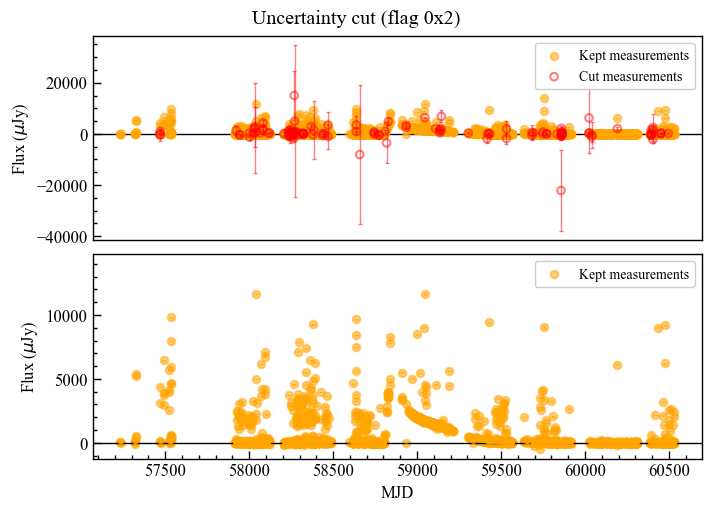

In [10]:
"""def plot_cut(lc: LightCurve, cut: Cut, lims: PlotLimits, title: str | None = None, save_filename:str=None):
	fig, (ax2, ax1) = plt.subplots(2, constrained_layout=True)
	fig.set_figwidth(7)
	fig.set_figheight(5)

	fig.suptitle(f'{title} (flag {hex(cut.flag)})')

	ax1.minorticks_on()
	ax1.tick_params(direction='in', which='both')
	ax2.get_xaxis().set_ticks([])
	ax1.set_ylabel(r'Flux ($\mu$Jy)')
	ax1.axhline(linewidth=1, color='k')

	ax2.minorticks_on()
	ax2.tick_params(direction='in', which='both')
	ax2.set_ylabel(r'Flux ($\mu$Jy)')
	ax1.set_xlabel('MJD')
	ax2.axhline(linewidth=1, color='k')

	good_ix = lc.get_good_indices(cut)
	bad_ix = lc.get_bad_indices(cut)
	sn_flux_color = SN_FLUX_COLORS[lc.filt]
	
	ax1.errorbar(lc.t.loc[good_ix,'MJD'], lc.t.loc[good_ix,'uJy'], yerr=lc.t.loc[good_ix,lc.dflux_colname], fmt='none', ecolor=sn_flux_color, elinewidth=1, capsize=1.2, c=sn_flux_color, alpha=0.5)
	ax1.scatter(lc.t.loc[good_ix,'MJD'], lc.t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux_color, marker='o', alpha=0.5, label='Kept measurements')

	ax2.errorbar(lc.t.loc[good_ix,'MJD'], lc.t.loc[good_ix,'uJy'], yerr=lc.t.loc[good_ix,lc.dflux_colname], fmt='none', ecolor=sn_flux_color, elinewidth=1, capsize=1.2, c=sn_flux_color, alpha=0.5, zorder=5)
	ax2.scatter(lc.t.loc[good_ix,'MJD'], lc.t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux_color, marker='o', alpha=0.5, label='Kept measurements', zorder=5)

	ax2.errorbar(lc.t.loc[bad_ix,'MJD'], lc.t.loc[bad_ix,'uJy'], yerr=lc.t.loc[bad_ix,lc.dflux_colname], fmt='none', ecolor=SN_FLAGGED_FLUX_COLOR, elinewidth=1, capsize=1.2, c=SN_FLAGGED_FLUX_COLOR, alpha=0.5, zorder=10)
	ax2.scatter(lc.t.loc[bad_ix,'MJD'], lc.t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=SN_FLAGGED_FLUX_COLOR, facecolors='none', edgecolors=SN_FLAGGED_FLUX_COLOR, marker='o', alpha=0.5, label='Cut measurements', zorder=10)

	ax1.set_xlim(lims.xlower, lims.xupper)
	ax1.set_ylim(lims.ylower, lims.yupper)
	ax2.set_xlim(lims.xlower, lims.xupper)
	ax2.set_ylim(lims.ylower, lims.yupper)

	ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)
	ax2.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)

	# if not save_filename is None:
		# self.save_plot(save_filename)"""

uncert_cut = Cut(flag=hexstring_to_int(config["uncert_cut"]["flag"]))
sn_lc = sn.lcs[0]

lims = plot.get_lims(lc=sn_lc, indices=sn_lc.get_good_indices(uncert_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn_lc, uncert_cut.flag, lims, 'Uncertainty cut', save_filename = 'uncert_cut' if save else None)

# Plot the estimated true uncertainties

In [11]:
# TODO

# Plot the chi-square cut

In [12]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/x2_cut.png


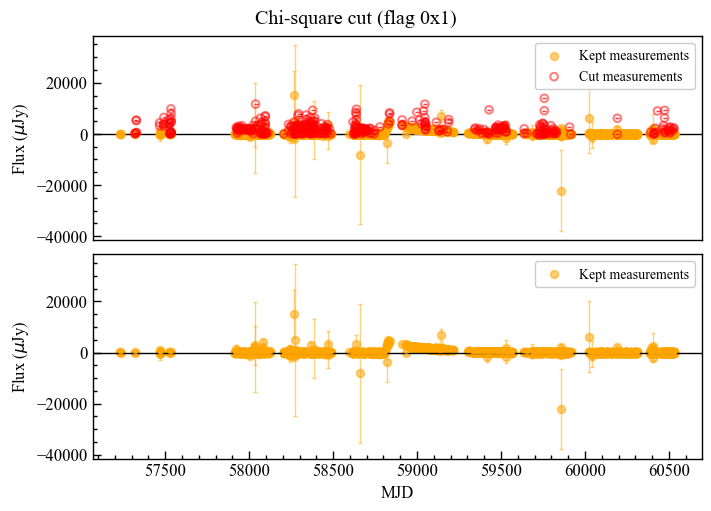

In [13]:
x2_cut = Cut(flag=hexstring_to_int(config["x2_cut"]["flag"]))
sn_lc = sn.lcs[0]

lims = plot.get_lims(lc=sn_lc, indices=sn_lc.get_good_indices(x2_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn_lc, x2_cut.flag, lims, 'Chi-square cut', save_filename = 'x2_cut' if save else None)

# Plot the control light curve cut

In [14]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/controls_cut.png


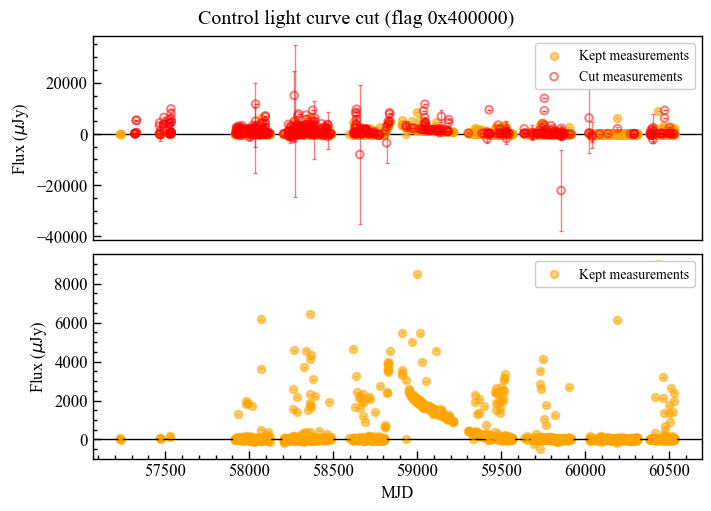

In [15]:
controls_cut = Cut(flag=hexstring_to_int(config["controls_cut"]["bad_flag"]))
sn_lc = sn.lcs[0]

lims = plot.get_lims(lc=sn_lc, indices=sn_lc.get_good_indices(controls_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn_lc, controls_cut.flag, lims, 'Control light curve cut', save_filename = 'controls_cut' if save else None)

# Plot custom cut(s)

In [16]:
# TODO

# Plot cleaned light curve using all previous cuts

In [17]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

In [18]:
cut_list = CutList()
cut_list.add(uncert_cut, 'uncert_cut')
cut_list.add(x2_cut, 'x2_cut')
cut_list.add(controls_cut, 'controls_cut')
# TODO: add custom cuts to list

lims = plot.get_lims(lc=sn_lc, indices=sn_lc.get_good_indices(cut_list.get_all_flags()), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cleaned_lc(sn_lc, cut_list.get_all_flags(), lims, save=save)

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]


# Plot averaged light curve

In [19]:
# TODO